# Introduction

DSCI 552 - Machine Learning for Data Science

Homework 5

Matheus Schmitz

USC ID: 5039286453

# Imports

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Scikit-Learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, hamming_loss, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Control downsampling of data to avoid long processing time during development
# 1 means 100% of data (no downsampling), 0.5 means 50% of data, and so on
DEV_DOWNSAMPLING = 1

## (a) Dataset

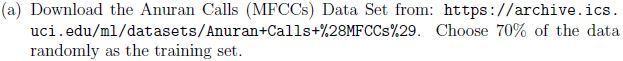

In [3]:
# Read csv
df = pd.read_csv('../data/Frogs_MFCCs.csv')
df = df.sample(frac=DEV_DOWNSAMPLING)
print(f'df.shape: {df.shape}')
df.head(3)

df.shape: (7195, 26)


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
6928,0.85101,0.660306,1.000000,0.397236,-0.090140,0.271438,0.234177,-0.135289,-0.103329,0.128048,...,-0.180056,0.063995,0.071453,-0.166078,0.082321,0.005049,Hylidae,Osteocephalus,OsteocephalusOophagus,50
6316,1.00000,0.553396,0.411580,0.250057,0.055848,0.130814,0.053127,-0.039142,0.099058,0.109447,...,0.003955,-0.003439,0.026140,-0.019745,-0.020744,0.070301,Hylidae,Hypsiboas,HypsiboasCordobae,42
4559,1.00000,0.098045,0.187311,0.565586,0.255289,0.058520,-0.169619,-0.063253,0.208254,0.049440,...,0.245413,-0.129530,-0.222279,-0.062927,0.190488,0.210858,Leptodactylidae,Adenomera,AdenomeraHylaedactylus,24


In [4]:
# Train-test split
df_train, df_test = train_test_split(df, test_size=0.3)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)
print(f'df_train.shape: {df_train.shape}')
print(f'df_test.shape: {df_test.shape}')

df_train.shape: (5036, 26)
df_test.shape: (2159, 26)


## (b) Multi-class and Multi-Label Classification

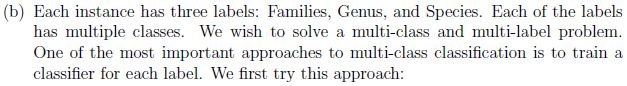

In [5]:
# Extract labels to be used
labels = [i for i in df.columns[-4:-1]]
labels

['Family', 'Genus', 'Species']

In [6]:
# Dataframes for Exact Match Loss
pred_train_labels = pd.DataFrame()
pred_test_labels = pd.DataFrame()

true_train_multilabel = df_train[labels].stack().groupby(level=0).apply(''.join).to_frame('true_train')
true_test_multilabel = df_test[labels].stack().groupby(level=0).apply(''.join).to_frame('true_test')

In [7]:
# Dataframes to store all results for comparison
summary = pd.DataFrame()
summary_multilabel = pd.DataFrame()

### (i) Exact Match and Hamming Score

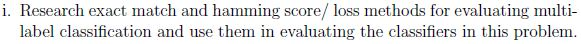

**Exact Match** only considers a classification as correct if all labels of the sample are correctly classified. It's a strict metric.

**Hamming Score** is the fraction of labels that are incorrectly predicted. It's a more lenient metric.

How to create a scorer with sklearn's make_scorer: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [8]:
# Create a loss function using the hamming_loss metric
hamm_loss = make_scorer(hamming_loss, greater_is_better=False)

### (ii) Gaussian Kernel SVM

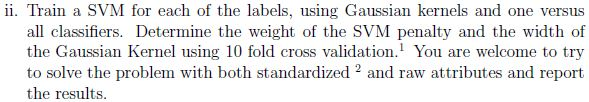

In [9]:
# Pipeline to standardize then run SVC
svc =  Pipeline([("standardize", StandardScaler()),
                 ("svc", SVC(kernel="rbf", decision_function_shape='ovr'))])

# Grid with parameters to be tested via CV
param_grid = {'svc__C': np.logspace(-3, 3, 7),
              'svc__gamma': np.logspace(-3, 3, 7)}

# Instantiate GridSearchCV using hamming_loss as the scorer
gridCV = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1, scoring=hamm_loss)

# Train one model for each label
for label in labels:

    # Get X's and Y's
    x_train = df_train.iloc[:, :-4].copy()
    y_train = df_train[label].copy()
    x_test = df_test.iloc[:, :-4].copy()
    y_test = df_test[label].copy()   

    # Fit using grid search to find the best params
    gridCV.fit(x_train, y_train)
    
    # Predict
    pred_train = gridCV.predict(x_train)
    pred_test = gridCV.predict(x_test)
    pred_train_labels[label] = pred_train
    pred_test_labels[label] = pred_test
    
    # Store data for later comparison
    summary.at['C', f'SVM_{label}'] = gridCV.best_params_['svc__C']
    summary.at['gamma', f'SVM_{label}'] = gridCV.best_params_['svc__gamma']
    summary.at['strict_train', f'SVM_{label}'] = 1 - accuracy_score(y_true=y_train, y_pred=pred_train)
    summary.at['strict_test', f'SVM_{label}'] = 1 - accuracy_score(y_true=y_test, y_pred=pred_test)
    summary.at['lenient_train', f'SVM_{label}'] = hamming_loss(y_true=y_train, y_pred=pred_train)
    summary.at['lenient_test', f'SVM_{label}'] = hamming_loss(y_true=y_test, y_pred=pred_test)
    
    # Print model results for current label
    print(f'------------------------------ {label} ------------------------------')
    print('Best C Parameter: ', summary.at['C', f'SVM_{label}'])
    print('Best Gamma Parameter: ', summary.at['gamma', f'SVM_{label}'])
    print()
    print('Exact Match Loss | Training: ', summary.at['strict_train', f'SVM_{label}'])
    print('Exact Match Loss | Testing: ', summary.at['strict_test', f'SVM_{label}'])
    print()
    print('Hamming Loss | Training: ', summary.at['lenient_train', f'SVM_{label}'])
    print('Hamming Loss | Testing: ', summary.at['lenient_test', f'SVM_{label}'])
    print()
    print()
    
# Model Overall metrics

# Join all predicted label strings to calculate exact match loss
pred_train_multilabel = pred_train_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_train')
pred_test_multilabel = pred_test_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_test')

# Multilabel Multiclass Exact Match
summary_multilabel.at['strict_train', 'SVM'] = 1 - accuracy_score(y_true=true_train_multilabel, y_pred=pred_train_multilabel)
summary_multilabel.at['strict_test', 'SVM'] = 1 - accuracy_score(y_true=true_test_multilabel, y_pred=pred_test_multilabel)

# The overall hamming loss is simply the average across all labels
summary_multilabel.at['lenient_train', 'SVM'] = summary.iloc[-2, -3:].mean()
summary_multilabel.at['lenient_test', 'SVM'] = summary.iloc[-1, -3:].mean()

# Print model results for entire model
print(f'------------------------------ MODEL OVERALL ------------------------------') 
print('Exact Match Loss | Training: ', summary_multilabel.at['strict_train', f'SVM'])
print('Exact Match Loss | Testing: ', summary_multilabel.at['strict_test', f'SVM'])
print()
print('Hamming Loss | Training: ', summary_multilabel.at['lenient_train', f'SVM'])
print('Hamming Loss | Testing: ', summary_multilabel.at['lenient_test', f'SVM'])
print()
print()

------------------------------ Family ------------------------------
Best C Parameter:  10.0
Best Gamma Parameter:  0.1

Exact Match Loss | Training:  0.0
Exact Match Loss | Testing:  0.012505789717461746

Hamming Loss | Training:  0.0
Hamming Loss | Testing:  0.012505789717461788


------------------------------ Genus ------------------------------
Best C Parameter:  10.0
Best Gamma Parameter:  0.01

Exact Match Loss | Training:  0.0027799841143765214
Exact Match Loss | Testing:  0.014358499305233918

Hamming Loss | Training:  0.0027799841143764893
Hamming Loss | Testing:  0.014358499305233904


------------------------------ Species ------------------------------
Best C Parameter:  10.0
Best Gamma Parameter:  0.01

Exact Match Loss | Training:  0.0019857029388403724
Exact Match Loss | Testing:  0.014821676702176934

Hamming Loss | Training:  0.0019857029388403494
Hamming Loss | Testing:  0.014821676702176934


------------------------------ MODEL OVERALL -----------------------------

### (iii) L1-Penalized SVM

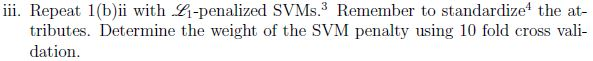

From Scikit-Learn about the dual parameter on LinearSVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

**dual bool, default=True**

Select the algorithm to either solve the dual or primal optimization problem.

Prefer `dual=False` when n_samples > n_features.

In [10]:
# Pipeline to standardize then run SVC
svc =  Pipeline([("standardize", StandardScaler()),
                 ("svc", LinearSVC(penalty="l1", multi_class='ovr', dual=False))])

# Grid with parameters to be tested via CV
param_grid = {'svc__C': np.logspace(-3, 3, 7)}

# Instantiate GridSearchCV using hamming_loss as the scorer
gridCV = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1, scoring=hamm_loss)

# Train one model for each label
for label in labels:

    # Get X's and Y's
    x_train = df_train.iloc[:, :-4].copy()
    y_train = df_train[label].copy()
    x_test = df_test.iloc[:, :-4].copy()
    y_test = df_test[label].copy()   

    # Fit using grid search to find the best params
    gridCV.fit(x_train, y_train)
    
    # Predict
    pred_train = gridCV.predict(x_train)
    pred_test = gridCV.predict(x_test)
    pred_train_labels[label] = pred_train
    pred_test_labels[label] = pred_test
    
    # Store data for later comparison
    summary.at['C', f'L1_{label}'] = gridCV.best_params_['svc__C']
    summary.at['strict_train', f'L1_{label}'] = 1 - accuracy_score(y_true=y_train, y_pred=pred_train)
    summary.at['strict_test', f'L1_{label}'] = 1 - accuracy_score(y_true=y_test, y_pred=pred_test)
    summary.at['lenient_train', f'L1_{label}'] = hamming_loss(y_true=y_train, y_pred=pred_train)
    summary.at['lenient_test', f'L1_{label}'] = hamming_loss(y_true=y_test, y_pred=pred_test)

    # Print model results for current label    
    print(f'------------------------------ {label} ------------------------------')
    print('Best C Parameter: ', summary.at['C', f'L1_{label}'])
    print()
    print('Exact Match Loss | Training: ', summary.at['strict_train', f'L1_{label}'])
    print('Exact Match Loss | Testing: ', summary.at['strict_test', f'L1_{label}'])
    print()
    print('Hamming Loss | Training: ', summary.at['lenient_train', f'L1_{label}'])
    print('Hamming Loss | Testing: ', summary.at['lenient_test', f'L1_{label}'])
    print()
    print()
    
# Model Overall metrics

# Join all predicted label strings to calculate exact match loss
pred_train_multilabel = pred_train_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_train')
pred_test_multilabel = pred_test_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_test')

# Multilabel Multiclass Exact Match
summary_multilabel.at['strict_train', 'L1'] = 1 - accuracy_score(y_true=true_train_multilabel, y_pred=pred_train_multilabel)
summary_multilabel.at['strict_test', 'L1'] = 1 - accuracy_score(y_true=true_test_multilabel, y_pred=pred_test_multilabel)

# The overall hamming loss is simply the average across all labels
summary_multilabel.at['lenient_train', 'L1'] = summary.iloc[-2, -3:].mean()
summary_multilabel.at['lenient_test', 'L1'] = summary.iloc[-1, -3:].mean()

# Print model results for entire model
print(f'------------------------------ MODEL OVERALL ------------------------------') 
print('Exact Match Loss | Training: ', summary_multilabel.at['strict_train', f'L1'])
print('Exact Match Loss | Testing: ', summary_multilabel.at['strict_test', f'L1'])
print()
print('Hamming Loss | Training: ', summary_multilabel.at['lenient_train', f'L1'])
print('Hamming Loss | Testing: ', summary_multilabel.at['lenient_test', f'L1'])
print()
print()

------------------------------ Family ------------------------------
Best C Parameter:  10.0

Exact Match Loss | Training:  0.05996822875297858
Exact Match Loss | Testing:  0.07132931912922647

Hamming Loss | Training:  0.05996822875297855
Hamming Loss | Testing:  0.07132931912922649


------------------------------ Genus ------------------------------
Best C Parameter:  1000.0

Exact Match Loss | Training:  0.046068308181096085
Exact Match Loss | Testing:  0.05326540064844831

Hamming Loss | Training:  0.046068308181096106
Hamming Loss | Testing:  0.053265400648448355


------------------------------ Species ------------------------------
Best C Parameter:  10.0

Exact Match Loss | Training:  0.034551231135822036
Exact Match Loss | Testing:  0.04261232051875874

Hamming Loss | Training:  0.034551231135822084
Hamming Loss | Testing:  0.042612320518758684


------------------------------ MODEL OVERALL ------------------------------
Exact Match Loss | Training:  0.07525814138204923
Exact

### (iv) SMOTE + L1-Penalized SVM

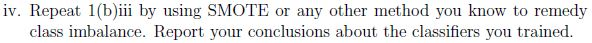

**Route #1: Applying Smote to the Whole Dataset**

In [11]:
# SMOTE: Data Preparation
smote = SMOTE(n_jobs=-1)

# Dictionaries to store the datasets for each SMOTE round (SMOTE needs to be done once per label)
master_dict_train = {}
master_dict_test = {}

# Create one SMOTE'd dataset per label
for label in labels:
    
    # Split data (required for smote)
    x_train = df_train.iloc[:, :-4].copy()
    y_train = df_train[label].copy()
    x_test = df_test.iloc[:, :-4].copy()
    y_test = df_test[label].copy()

    # Apply SMOTE 
    tuple_train_smote = smote.fit_sample(x_train, y_train)
    tuple_test_smote = smote.fit_sample(x_test, y_test) # (code here for experimentation purposes)

    # UNDO the SMOTE on the test dataset, as it doesn't make sense to apply SMOTE to it 
    tuple_test_smote = (x_test, y_test)
    
    # Get original column names
    col_names = [i for i in df.columns[:-4]]
    col_names.append(label)

    # Reconstruct the dataframes
    df_train_smote = pd.concat([tuple_train_smote[0], tuple_train_smote[1]], axis=1)
    df_train_smote.columns = col_names
    df_test_smote = pd.concat([tuple_test_smote[0], tuple_test_smote[1]], axis=1)
    df_test_smote.columns = col_names
    
    # Save dataframes to the dict
    master_dict_train[label] = df_train_smote
    master_dict_test[label] = df_test_smote

In [12]:
# Pipeline to standardize then run SVC
svc =  Pipeline([("standardize", StandardScaler()),
                 ("svc", LinearSVC(penalty="l1", multi_class='ovr', dual=False))])

# Grid with parameters to be tested via CV
param_grid = {'svc__C': np.logspace(-3, 3, 7)}

# Instantiate GridSearchCV using hamming_loss as the scorer
gridCV = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1, scoring=hamm_loss)

# Train one model for each label
for label in labels:

    # Get X's and Y's
    x_train = master_dict_train[label].iloc[:, :-1].copy()
    y_train = master_dict_train[label][label].copy()
    x_test = master_dict_test[label].iloc[:, :-1].copy()
    y_test = master_dict_test[label][label].copy()

    # Fit using grid search to find the best params
    gridCV.fit(x_train, y_train)
    
    # Predict
    pred_train = gridCV.predict(x_train)
    pred_test = gridCV.predict(x_test)
    #pred_train_labels[label] = pred_train
    pred_test_labels[label] = pred_test
    
    # Store data for later comparison
    summary.at['C', f'SMOTE_{label}'] = gridCV.best_params_['svc__C']
    summary.at['strict_train', f'SMOTE_{label}'] = 1 - accuracy_score(y_true=y_train, y_pred=pred_train)
    summary.at['strict_test', f'SMOTE_{label}'] = 1 - accuracy_score(y_true=y_test, y_pred=pred_test)
    summary.at['lenient_train', f'SMOTE_{label}'] = hamming_loss(y_true=y_train, y_pred=pred_train)
    summary.at['lenient_test', f'SMOTE_{label}'] = hamming_loss(y_true=y_test, y_pred=pred_test)

    # Print model results for current label    
    print(f'------------------------------ {label} ------------------------------')
    print('Best C Parameter: ', summary.at['C', f'SMOTE_{label}'])
    print()
    print('Exact Match Loss | Training: ', summary.at['strict_train', f'SMOTE_{label}'])
    print('Exact Match Loss | Testing: ', summary.at['strict_test', f'SMOTE_{label}'])
    print()
    print('Hamming Loss | Training: ', summary.at['lenient_train', f'SMOTE_{label}'])
    print('Hamming Loss | Testing: ', summary.at['lenient_test', f'SMOTE_{label}'])
    print()
    print()
    
# Model Overall metrics

# Join all predicted label strings to calculate exact match loss
#pred_train_multilabel = pred_train_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_train')
pred_test_multilabel = pred_test_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_test')

# Multilabel Multiclass Exact Match
#summary_multilabel.at['strict_train', 'SMOTE'] = 1 - accuracy_score(y_true=true_train_multilabel, y_pred=pred_train_multilabel)
summary_multilabel.at['strict_test', 'SMOTE'] = 1 - accuracy_score(y_true=true_test_multilabel, y_pred=pred_test_multilabel)

# The overall hamming loss is simply the average across all labels
summary_multilabel.at['lenient_train', 'SMOTE'] = summary.iloc[-2, -3:].mean()
summary_multilabel.at['lenient_test', 'SMOTE'] = summary.iloc[-1, -3:].mean()

# Print model results for entire model
print(f'------------------------------ MODEL OVERALL ------------------------------') 
#print('Exact Match Loss | Training: ', summary_multilabel.at['strict_train', f'SMOTE'])
print('As each label on training data has its unique SMOTEd dataset, training Exact Match Loss cannot be calculated')
print('Exact Match Loss | Testing: ', summary_multilabel.at['strict_test', f'SMOTE'])
print()
print('Hamming Loss | Training: ', summary_multilabel.at['lenient_train', f'SMOTE'])
print('Hamming Loss | Testing: ', summary_multilabel.at['lenient_test', f'SMOTE'])
print()
print()

------------------------------ Family ------------------------------
Best C Parameter:  10.0

Exact Match Loss | Training:  0.048983214977404765
Exact Match Loss | Testing:  0.08568781843446038

Hamming Loss | Training:  0.04898321497740478
Hamming Loss | Testing:  0.0856878184344604


------------------------------ Genus ------------------------------
Best C Parameter:  10.0

Exact Match Loss | Training:  0.04365966964900203
Exact Match Loss | Testing:  0.08568781843446038

Hamming Loss | Training:  0.043659669649002066
Hamming Loss | Testing:  0.0856878184344604


------------------------------ Species ------------------------------
Best C Parameter:  10.0

Exact Match Loss | Training:  0.04034299714169054
Exact Match Loss | Testing:  0.04539138490041683

Hamming Loss | Training:  0.040342997141690484
Hamming Loss | Testing:  0.04539138490041686


------------------------------ MODEL OVERALL ------------------------------
As each label on training data has its unique SMOTEd dataset, 

**Route #2: Applying Smote to K-1 Folds**

This approach takes much slower then the above one which applies SMOTE once to the whole dataset and then performs GridSearchCV

To make the processing time more reasonable I shrank the param_grid, keeping only the C range found in the above summary, plus and minus one log.

Also, since the cross-validation is already being performed via K-fold splitting, I reduced the cv parameter inside GridSearch to 5 (down from 10), which halves the processing time, as my CPU has 8 cores, which means a cv of 10 requires two "cycles" (as 2 of the folds will have to wait for a core to become available), while a cv of 5 can be completed in one "cycle".

Still, the cell below takes about 1 hour to run.

In [13]:
%%time
# This cell takes close to 1 hour

# Instantiate SMOTE
smote = SMOTE(n_jobs=-1)

# Pipeline to standardize then run SVC
svc =  Pipeline([("standardize", StandardScaler()),
                 ("svc", LinearSVC(penalty="l1", multi_class='ovr', dual=False))])

# Grid with parameters to be tested via CV
param_grid = {'svc__C': np.logspace(0, 3, 4)}

# Instantiate GridSearchCV using hamming_loss as the scorer
gridCV = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, scoring=hamm_loss)

# KFold
kf = KFold(n_splits=10, shuffle=True)

# For each label, split the data in 10 folds, using 9 for training and 1 for validation
for label in labels:
    print(f'------------------------------ {label} ------------------------------')
    kfold_intermediate_results = pd.DataFrame()
    for fold_num, (idx_train, idx_valid) in enumerate(kf.split(df_train), 1):
        
        # Print current label and fold
        print(f'Working on Fold: {fold_num}')

        # Select all folds to be smoted except for the validation fold
        x_train, y_train = smote.fit_sample(df_train.iloc[idx_train,:-4], df_train[label].iloc[idx_train])
        x_valid = df_train.iloc[idx_valid,:-4] 
        y_valid = df_train[label].iloc[idx_valid]
          
        # Fit using grid search to find the best params
        gridCV.fit(x_train, y_train)

        # Predict on the train and validation folds to calculate metrics
        pred_train = gridCV.predict(x_train)   
        pred_valid = gridCV.predict(x_valid)   
        
        # Store K-Fold intermedaite results
        kfold_intermediate_results.at['C', f'{fold_num}'] = gridCV.best_params_['svc__C']
        kfold_intermediate_results.at['strict_train', f'{fold_num}'] = 1 - accuracy_score(y_true=y_train, y_pred=pred_train)
        kfold_intermediate_results.at['strict_valid', f'{fold_num}'] = 1 - accuracy_score(y_true=y_valid, y_pred=pred_valid)
        kfold_intermediate_results.at['lenient_train', f'{fold_num}'] = hamming_loss(y_true=y_train, y_pred=pred_train)
        kfold_intermediate_results.at['lenient_valid', f'{fold_num}'] = hamming_loss(y_true=y_valid, y_pred=pred_valid)
    
    # After running all K-Folds get average results for the label
    kfold_intermediate_results['mean'] = kfold_intermediate_results.mean(axis=1)
    
    print()
    print(f'--- K-Fold Cross-Validation Results ---')
    print(f'Mean C Parameter: {kfold_intermediate_results["mean"]["C"]}')
    print()
    print(f'Mean Exact Match Loss | Training : {kfold_intermediate_results["mean"]["strict_train"]}')
    print(f'Mean Exact Match Loss | Validation : {kfold_intermediate_results["mean"]["strict_valid"]}')
    print()
    print(f'Mean Hamming Loss | Training : {kfold_intermediate_results["mean"]["lenient_train"]}')
    print(f'Mean Hamming Loss | Validation : {kfold_intermediate_results["mean"]["lenient_valid"]}')
    print()
    
    # Create a classifier using the mean C value
    svc_kfold = LinearSVC(penalty="l1", multi_class='ovr', dual=False,
                          C=kfold_intermediate_results.at['C', 'mean'])
    
    # Get X's and Y's - This time using the full datasets for trainin and testing
    x_train, y_train = smote.fit_sample(df_train.iloc[:,:-4], df_train[label])
    x_test = df_test.iloc[:, :-4].copy()
    y_test = df_test[label].copy()
    
    # Fit using the SVM model created with the mean C from K-Fold cross-validation
    svc_kfold.fit(x_train, y_train)
    
    # Predict
    pred_train = svc_kfold.predict(x_train)
    pred_test = svc_kfold.predict(x_test)
    #pred_train_labels[label] = pred_train
    pred_test_labels[label] = pred_test
    
    # Store data for later comparison
    summary.at['C', f'SMOTE_KF_{label}'] = svc_kfold.C
    summary.at['strict_train', f'SMOTE_KF_{label}'] = 1 - accuracy_score(y_true=y_train, y_pred=pred_train)
    summary.at['strict_test', f'SMOTE_KF_{label}'] = 1 - accuracy_score(y_true=y_test, y_pred=pred_test)
    summary.at['lenient_train', f'SMOTE_KF_{label}'] = hamming_loss(y_true=y_train, y_pred=pred_train)
    summary.at['lenient_test', f'SMOTE_KF_{label}'] = hamming_loss(y_true=y_test, y_pred=pred_test)

    # Print model results for current label    
    print(f'--- Full Dataset Results ---')
    print('Exact Match Loss | Training: ', summary.at['strict_train', f'SMOTE_KF_{label}'])
    print('Exact Match Loss | Testing: ', summary.at['strict_test', f'SMOTE_KF_{label}'])
    print()
    print('Hamming Loss | Training: ', summary.at['lenient_train', f'SMOTE_KF_{label}'])
    print('Hamming Loss | Testing: ', summary.at['lenient_test', f'SMOTE_KF_{label}'])
    print()
    print()
    
# Model Overall metrics

# Join all predicted label strings to calculate exact match loss
#pred_train_multilabel = pred_train_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_train')
pred_test_multilabel = pred_test_labels.stack().groupby(level=0).apply(''.join).to_frame('pred_test')

# Multilabel Multiclass Exact Match
#summary_multilabel.at['strict_train', 'SMOTE_KF'] = 1 - accuracy_score(y_true=true_train_multilabel, y_pred=pred_train_multilabel)
summary_multilabel.at['strict_test', 'SMOTE_KF'] = 1 - accuracy_score(y_true=true_test_multilabel, y_pred=pred_test_multilabel)

# The overall hamming loss is simply the average across all labels
summary_multilabel.at['lenient_train', 'SMOTE_KF'] = summary.iloc[-2, -3:].mean()
summary_multilabel.at['lenient_test', 'SMOTE_KF'] = summary.iloc[-1, -3:].mean()

# Print model results for entire model
print(f'------------------------------ MODEL OVERALL ------------------------------') 
#print('Exact Match Loss | Training: ', summary_multilabel.at['strict_train', f'SMOTE_KF'])
print('As each label on training data has its unique SMOTEd dataset, training Exact Match Loss cannot be calculated')
print('Exact Match Loss | Testing: ', summary_multilabel.at['strict_test', f'SMOTE_KF'])
print()
print('Hamming Loss | Training: ', summary_multilabel.at['lenient_train', f'SMOTE_KF'])
print('Hamming Loss | Testing: ', summary_multilabel.at['lenient_test', f'SMOTE_KF'])
print()
print()

------------------------------ Family ------------------------------
Working on Fold: 1
Working on Fold: 2
Working on Fold: 3
Working on Fold: 4
Working on Fold: 5
Working on Fold: 6
Working on Fold: 7
Working on Fold: 8
Working on Fold: 9
Working on Fold: 10

--- K-Fold Cross-Validation Results ---
Mean C Parameter: 135.1

Mean Exact Match Loss | Training : 0.046624881761727945
Mean Exact Match Loss | Validation : 0.081022989049828

Mean Hamming Loss | Training : 0.046624881761727924
Mean Hamming Loss | Validation : 0.081022989049828

--- Full Dataset Results ---
Exact Match Loss | Training:  0.04728857327307945
Exact Match Loss | Testing:  0.0861509958314034

Hamming Loss | Training:  0.04728857327307941
Hamming Loss | Testing:  0.08615099583140343


------------------------------ Genus ------------------------------
Working on Fold: 1
Working on Fold: 2
Working on Fold: 3
Working on Fold: 4
Working on Fold: 5
Working on Fold: 6
Working on Fold: 7
Working on Fold: 8
Working on Fold: 

Quite interestingly, for all labels a lower training and validation error is achieved when the model's parameters are found this this approach, versus the approach that uses only GridSearchCV but no K-Folds.

Yet, this does not translate into lower test error, suggesting that either the model is starting to overfit, or it has reached the limit of the dataset.

### Summary of Classifiers

In [14]:
row_names = {'strict_train': 'Exact Match Loss | Train',
             'strict_test': 'Exact Match Loss | Test',
             'lenient_train': 'Hamming Loss | Train',
             'lenient_test': 'Hamming Loss | Test'}

In [15]:
# Summary of single-label classifiers
summary.rename(row_names)

,SVM_Family,SVM_Genus,SVM_Species,L1_Family,L1_Genus,L1_Species,SMOTE_Family,SMOTE_Genus,SMOTE_Species,SMOTE_KF_Family,SMOTE_KF_Genus,SMOTE_KF_Species
C,10.000000,10.000000,10.000000,10.000000,1000.000000,10.000000,10.000000,10.000000,10.000000,135.100000,72.100000,244.000000
gamma,0.100000,0.010000,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exact Match Loss | Train,0.000000,0.002780,0.001986,0.059968,0.046068,0.034551,0.048983,0.043660,0.040343,0.047289,0.045380,0.043324
Exact Match Loss | Test,0.012506,0.014358,0.014822,0.071329,0.053265,0.042612,0.085688,0.085688,0.045391,0.086151,0.092172,0.045855
Hamming Loss | Train,0.000000,0.002780,0.001986,0.059968,0.046068,0.034551,0.048983,0.043660,0.040343,0.047289,0.045380,0.043324
Hamming Loss | Test,0.012506,0.014358,0.014822,0.071329,0.053265,0.042612,0.085688,0.085688,0.045391,0.086151,0.092172,0.045855


Exact Match Loss is only more strict that Hamming Losss when there is more than 1 label to be predicted at the same time. Hence it was already expected that they would match for the single-label problems.

In [16]:
# Summary of multi-label classifiers
# As each label on training data has its unique SMOTEd dataset, training Exact Match Loss cannot be calculated
summary_multilabel.rename(row_names)

,SVM,L1,SMOTE,SMOTE_KF
Exact Match Loss | Train,0.003177,0.075258,NaN,NaN
Exact Match Loss | Test,0.024085,0.091709,0.144511,0.147290
Hamming Loss | Train,0.001589,0.046863,0.044329,0.045331
Hamming Loss | Test,0.013895,0.055736,0.072256,0.074726


The original SVM Classifier was the best performing model, which was expected given the known fact that L1 penalization can at best match an un-penalized model, and most likely will have a higher error, thus the following models which employed L1 were bound to underperform, as a tradeoff for the feature selection they provide.

The more interesting aspect is how SMOTE seems to have worsened (increased) the misclassification rate (error). One way to dive deeper into this issue would be to check the class-stratified misclassification rate, to see if the error for the rare classes got reduced at the expense of error in the majority class increasing.